In [3]:
from IPython.core.display import HTML
HTML("""
<style>
img {
    display: inline;
    text-align: center;
}
.center {
    text-align: center;
}
</style>
""")

On the [Cross Validate](http://stats.stackexchange.com/) website one person asked for a code that implements neural network in SQL and it caught my attention so I decided to give it a try. Unfortunately, the queston have been deleted from the website, but I've managed to get a screen shot from the cached web page in the google search. So here it is:

![](/images/cv-question.png)

The question is kind of funny, but I can understand why the person asked such a question. Lots of papers and books can look a bit complicated and ovewhelming due to math and terminology that is used and people try to find a more familiar way for them to understand neural networks. Anyway, the question in some way looks interesting to me. After reading that, I started thinking how it can be implemented and then I came up with a simple solution that I'm going to present here as a main point of this article.

Before I start I would like to clarify a few things. So the first one is that it's not a real work or something that you can use practically, I made it just for fun. The solution is not flexible and it's hard to scale it (but possible). The second thing is that I've made a simple working prototype, so there are probably some places in the code that can be optimized and simplified, but again, I don't care about the speed or accuracy. The main point is to make it work. However, I will be happy to add some improvements to the code if somebody is interested.

I've added three tables that contain the most important information. The Dataset and DatasetClass tables contain all the information about the dataset. As you can see in the figure below, the tables have a very simpe structure, but if you look closely at Dataset and Parameters tables, they might appear a bit odd. Basically, they are matrices. Each row stores information about a cell in this matrix. There are three main properties that each cell value from the matrix should have: row index, column index and value. Why this format is better, we will see soon.

<p class="center">
<img src="/images/nnet-scheme.png">
</p>

Since the database scheme has been created, we are able to add the data inside the Dataset table. I've used a toy dataset for simplicity. Here's how it looks like.

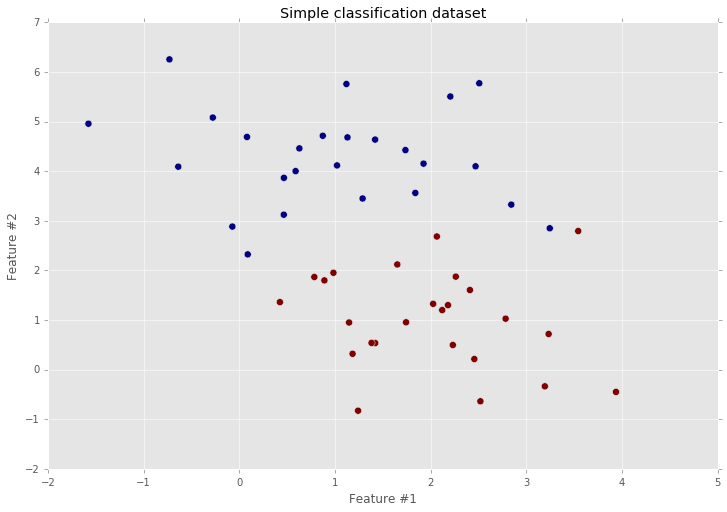

In [6]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
np.random.seed(0)

data, target = datasets.make_blobs(n_samples=50, n_features=2,
                                   centers=2)

plt.figure(figsize=(12, 8))
plt.scatter(*data.T, c=target, s=50)

plt.title("Simple classification dataset")
plt.xlabel("Feature #1")
plt.ylabel("Feature #2")
plt.show()

As you can see, the classification task is very simple and it is going to be easier to find a good solution using a simple neural network without hidden layers.

In [2]:
# for row in np.concatenate([data, target.reshape((-1, 1))], axis=1):
#     print("({:.7f}, {:.7f}, {:.0f}),".format(*row))

Next we need to define a default parameters for the network.

{% highlight sql %}
INSERT INTO Parameters VALUES
(1, 1, RAND(123) - 0.5), -- Weight #1
(2, 1, RAND(234) - 0.5), -- Weight #2
(3, 1, RAND(345) - 0.5); -- Bias
{% endhighlight %}

There is an important thing that should be noted about the code above. The random functions include seed parameter. It means that all the weight will be reproducible, but you can withdraw it if you want.

Here is the weights that you should see in the Parameters table.

|RowIndex|ColumnIndex|Weight|
|-------|-----|-----|
|1|1|0.4277429|
|2|1|0.1980680|
|3|1|-0.0316069|

Now tables contain all data that we need. Next we need to have a function that trains the network. This step is a bit more complicated. I've splitted the training function into small pieces that are easier to implement.

1. Matrix product between weights and dataset
2. Output computation from network
3. Error calculation
4. Gradients computation
5. Weights updating using gradient descent algorithm

The first step is not as easy as it may seem. But I tried to do it as simple as possible. I made all sum and product operations within all columns and parameters in the SQL select statement. This solution is not flexible at all. But here is a more flexible way to do the matrix product in MySQL.

{% highlight sql %}
CREATE TABLE InputData (
    RowIndex INT,
    ColumnIndex INT,
    CellValue Double(10, 7)
);

INSERT INTO InputData VALUES
(1, 1, 1),
(1, 2, 2),
(1, 3, 3),
(2, 1, 4),
(2, 2, 5),
(2, 3, 6);

CREATE TABLE NNParameters (
    RowIndex INT,
    ColumnIndex INT,
    Weight DECIMAL(10, 7)
);

INSERT INTO NNParameters VALUES
(1, 1, 1),
(1, 2, 2),
(2, 1, 3),
(2, 2, 4),
(3, 1, 5),
(3, 2, 6);

SELECT
    InputData.RowIndex,
    NNParameters.ColumnIndex, 
    SUM(Weight * CellValue) as MatrixProductValue
FROM InputData
CROSS JOIN NNParameters
    ON InputData.ColumnIndex = NNParameters.RowIndex
GROUP BY
    InputData.RowIndex,
    NNParameters.ColumnIndex;
{% endhighlight %}

The code above makes simple matrix product operation between two matrices. Here is how the same code looks in terms of mathematical formulation:

$$
\begin{bmatrix}
    1 & 2 & 3 \\
    4 & 5 & 6 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
    1 & 2 \\
    3 & 4 \\
    5 & 6 \\
\end{bmatrix}
=
\begin{bmatrix}
    22 & 28 \\
    49 & 64 \\
\end{bmatrix}
$$

If you run the previous code you will get this table:

|RowIndex|ColumnIndex|MatrixProductValue|
|-|-|----------|
|1|1|22.0000000|
|1|2|28.0000000|
|2|1|49.0000000|
|2|2|64.0000000|


It's easy to read the table. But if you had more elements in matrix it wouldn't be like that.

Next step is a nonlinearity. In MySQL it is easy to make a function.

{% highlight sql %}
DELIMITER //
CREATE FUNCTION SIGMOID(x DECIMAL(10, 7))
    RETURNS DECIMAL(10, 7)
    READS SQL DATA
    DETERMINISTIC
    BEGIN
        RETURN 1 / (1 + EXP(-x));	
    END//
DELIMITER ;
{% endhighlight %}

As an error function I used cross entropy. I defined it in a similar way with a few other function that will become useful later in process. So now we can create a forward propagation throught the network and compute its loss. Let's put everything together and see what we get.

{% highlight sql %}
SELECT
    Dataset.RowIndex,
    SIGMOID(SUM(Weight * CellValue)) as Output
FROM Dataset
CROSS JOIN Parameters
    ON Dataset.ColumnIndex = Parameters.RowIndex
GROUP BY Dataset.RowIndex, Parameters.ColumnIndex
{% endhighlight %}

The last query makes a forward propagation through the network and produces two values. The first one is a row index that defines sample from the dataset. And the second one is a network output that defines probability. Here is network's prediction for the first five samples:

|RowIndex|Output|
|--------|------|
|1|0.6848528|
|2|0.7493200|
|3|0.8303425|
|4|0.8625787|
|5|0.7528145|


We can easely check the accuracy score

{% highlight sql %}
SELECT
    AVG(CAST(Class AS UNSIGNED) = ROUND(Result.Output)) as Accuracy
FROM (
    SELECT
        Dataset.RowIndex,
        SIGMOID(SUM(Weight * CellValue)) as Output
    FROM Dataset
    CROSS JOIN Parameters
        ON Dataset.ColumnIndex = Parameters.RowIndex
    GROUP BY Dataset.RowIndex, Parameters.ColumnIndex
) as Result
LEFT JOIN DatasetClass
ON DatasetClass.RowIndex = Result.RowIndex;
{% endhighlight %}

|Accuracy|
|--------|
|0.5000|

The next step is a backward propagation. I tried a solution that will be flexible and can be useful for datasets that have arbitrary number of features. So I started the backward propagation with an update step. Here is how I managed to do the weight update procedure:

{% highlight sql %}
UPDATE Parameters
LEFT JOIN (
    -- TODO: Add SQL Query that computes gradients
) as Updates
ON Updates.ColumnIndex = Parameters.RowIndex
SET Weight = Weight - Step * Updates.Gradient;
{% endhighlight %}

And finally, we can compute the gradient.

{% highlight sql %}
SELECT
    Dataset.ColumnIndex,
    AVG(R.IncompleteGradient * CellValue) as Gradient
FROM(
    SELECT 
        Result.RowIndex,
        Result.ColumnIndex,
        GRAD_CROSSENTROPY(DatasetClass.Class, Output) *
            Output * (1 - Output) as IncompleteGradient
    FROM (
        -- Query that computes output from the network
    ) as Result
    LEFT JOIN DatasetClass
    ON DatasetClass.RowIndex = Result.RowIndex
) as R
CROSS JOIN Dataset ON Dataset.RowIndex = R.RowIndex
GROUP BY R.ColumnIndex, Dataset.ColumnIndex
{% endhighlight %}

At this point we have everything we need to train the network. Now we can combine everything in MySQL procedure. That takes two parameters: step size and number of epochs.

{% highlight sql %}
CREATE PROCEDURE Training(Epochs INT, Step DECIMAL(10, 7))
BEGIN
    DECLARE i INT;
    SET i = 1;
    
    WHILE i <= Epochs DO
        SET i = i + 1;
        -- Update weights
    END WHILE;
END//
DELIMITER ;
{% endhighlight %}

And that's it. Let's try to train the network.

{% highlight sql %}
CALL TrainNetwork(7000, 0.01);
{% endhighlight %}

I've trained it for 7000 epochs with step size equals to 0,01. Let's check the accuracy.

|Accuracy|
|--------|
|0.9800|

Awesome! The network has been trained succesfully.

All the code you can find in the [GitHub repository](https://github.com/itdxer/Neural-Network-in-MySQL).